# Seq2Class Model

Jose Amezquita and Jon Amitai'<br><br>


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive') #mounts google colab to my drive. Can be commented out when running locally

# %cd /content/drive/MyDrive/"Colab Notebooks"/"us-patent-phrase-to-phrase-matching"

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/us-patent-phrase-to-phrase-matching


In [ ]:
# !pip install tensorflow==2.4.0
# !pip install numpy==1.19.5

In [ ]:
import numpy as np
from tqdm.notebook import tqdm
import pandas
from IPython.display import display
from sklearn.model_selection import train_test_split

# Data Preprocessing

#### Load and Split Data

In [ ]:
#load the data. If it is that training then return scores and table wothout the scores
#For testing just return the pandas dataframe
def load_data(path, test=False):
    data = pandas.read_csv(path)
    if not test:
        data = data.drop(['id'], axis = 1)
        # display(data)
        # data = data.to_numpy()

        # ah = data.loc[data['score'] == .5]

        # ah.to_csv("example.csv", index=False)

        data_output = data["score"]
        data_input = data.drop(['score'], axis=1)
        return data_input, data_output

    else:
        return data

train_data, train_scores = load_data("train.csv")
test_data = load_data("test.csv", True)



display(train_data.shape)
# display(train_scores)
display(test_data.shape)

#for testing purposes use less data
# train_data = train_data[:10000]
# train_scores = train_scores[:10000]

data_train, data_val, scores_train, scores_val = train_test_split(train_data, train_scores, test_size=0.2)#split data into validation and training
data_train, data_ver, scores_train, scores_ver = train_test_split(data_train, scores_train, test_size=0.2)#split data into testing and training

print('The size of the training set:', len(data_train))
print('The size of the validation set:', len(data_val))
print('The size of the verification set:', len(data_ver))
print('The size of the test set:', len(test_data))

(36473, 3)

(36, 4)

The size of the training set: 23342
The size of the validation set: 7295
The size of the verification set: 5836
The size of the test set: 36


In [ ]:
(train_data['context'].value_counts())

H01    2186
H04    2177
G01    1812
A61    1477
F16    1091
       ... 
B03      47
F17      33
B31      24
A62      23
F26      18
Name: context, Length: 106, dtype: int64

### Preprocess Data

In [ ]:
import re
import string
import spacy
from itertools import chain
from unicodedata import normalize, category

nlp_en = spacy.load('en_core_web_sm')
#tokenize the input
def tokenize(text):
    doc = nlp_en(text.lower())
    return [token.text for token in doc]
#for each text tokenize it
def preprocess(texts):
    return [tokenize(text) for text in tqdm(texts, desc="Preprocessing Data")]
#generate the vocab based on all the word in the target, anchor and context
def generate_vocab(tokenized_anchor, tokenized_target, contexts):
    tokenized_anchor = np.array(tokenized_anchor)
    tokenized_target = np.array(tokenized_target)
    vocab1 = list(chain.from_iterable(tokenized_anchor))
    vocab2 = list(chain.from_iterable(tokenized_target))
    vocab = np.concatenate((vocab1, vocab2, contexts))
    # unique, counts = np.unique(vocab1, return_counts=True)
    # print(dict(zip(unique,counts)))
    # print(vocab1.shape)
    return list(set(vocab))
#get vocab for entire dataset
anchor = train_data['anchor'].to_numpy()#get anchor
target = train_data['target'].to_numpy()#get targets
contexts = train_data['context'].to_numpy()#get contexts

anchor_tokens = preprocess(anchor)
target_tokens = preprocess(target)
#generate vocab
vocab = generate_vocab(anchor_tokens, target_tokens, contexts)
vocab.insert(0, "<unk>")
token2idx = {token: idx for idx, token in enumerate(vocab)}

print("Vocab Length:", len(vocab))
print(vocab)

Preprocessing Data:   0%|          | 0/36473 [00:00<?, ?it/s]

Preprocessing Data:   0%|          | 0/36473 [00:00<?, ?it/s]

Vocab Length: 9037
['<unk>', 'plaques', 'generative', 'run', 'polyolefins', 'biometric', 'kinetics', 'hold', 'wholesale', 'grasshopper', 'drops', 'engrave', 'make', 'biomimetics', 'be', 'carrier', 'biasing', 'recliner', 'prosthetic', 'expandable', 'carpets', 'syringe', 'glyciphage', 'commanded', 'creosote', 'variance', 'partners', 'carbs', 'rock', 'primers', 'chicken', 'aralkynyl', 'shannon', 'microprocessor', 'ribbon', 'dual', 'several', 'marks', 'ligands', 'resealing', 'perfluorinated', 'accelerator', 'uncoupled', 'digesting', 'highest', 'vasculogenesis', '2s3r4s5s6r', 'propellent', 'captions', 'impulse', 'organobromine', 'oxygen', 'formulae', 'congruity', 'metrics', 'gamma', 'traffic', 'powdery', 'slider', 'whole', 'polyamides', 'pile', 'micas', 'metadata', 'silicide', 'cup', 'optimization', 'american', 'preserving', 'milligrams', 'seepage', 'ole', 'garden', 'photophobia', 'earthing', 'spikes', 'badly', 'elongated', 'experimentally', 'compose', 'photo', 'netbenefits', 'constants', '

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
anchor_train = data_train['anchor'].to_numpy()
target_train = data_train['target'].to_numpy()
context_train = data_train['context'].to_numpy()

anchor_val = data_val['anchor'].to_numpy()
target_val = data_val['target'].to_numpy()
context_val = data_val['context'].to_numpy()

anchor_ver = data_ver['anchor'].to_numpy()
target_ver = data_ver['target'].to_numpy()
context_ver = data_ver['context'].to_numpy()


# print(token2idx)

# print(target_tokens)
# print(tokenize(target[0]))

#Get the training testing and validation datasets as a tuple of (anchor, target, contesxt)
train_set = [([token2idx[t] for t in tokenize(a)],[token2idx[t] for t in tokenize(b)],[token2idx[t] for t in ([c])]) for a,b,c in tqdm(list(zip(anchor_train, target_train, context_train)),desc="Processing Train Set:")]
val_set = [([token2idx[t] for t in tokenize(a)],[token2idx[t] for t in tokenize(b)],[token2idx[t] for t in ([c])]) for a,b,c in tqdm(list(zip(anchor_val, target_val, context_val)),desc="Processing Validation Set:")]
ver_set = [([token2idx[t] for t in tokenize(a)],[token2idx[t] for t in tokenize(b)],[token2idx[t] for t in ([c])]) for a,b,c in tqdm(list(zip(anchor_ver, target_ver, context_ver)),desc="Processing Verification Set:")]

Processing Train Set::   0%|          | 0/23342 [00:00<?, ?it/s]

Processing Validation Set::   0%|          | 0/7295 [00:00<?, ?it/s]

Processing Verification Set::   0%|          | 0/5836 [00:00<?, ?it/s]

In [ ]:
print("Train Set Size:", len(train_set))
print("Validation Set Size:", len(val_set))
print("Verification Set Size:", len(ver_set))

Train Set Size: 23342
Validation Set Size: 7295
Verification Set Size: 5836


# Model

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt 

# import numpy as np
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers
# from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.preprocessing.sequence import pad_sequences
# import matplotlib.pyplot as plt 

In [ ]:
tf.__version__

'2.8.0'

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

Num GPUs Available:  0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2112615757271262257
]


In [ ]:
vocab_len = len(vocab)
embedding_size = 300 #size of the embedding layer
hidden_size = 300 #size of the hidden layer
num_classes = 5

### Encoder

In [ ]:
#Encoder-Decoder First attempt Encoder

input1 = layers.Input(shape=(None,), name="Context_Input")#take in conetxt
input2 = layers.Input(shape = (None, ), name="Anchor_Input")#take in anchor
embedding = layers.Embedding(input_dim=vocab_len, output_dim =  embedding_size, name="Encoder_Embedding")#embedding layer
embed1 = embedding(input1)#embed context
embed2 = embedding(input2)#embed anchor
# concatted = layers.Concatenate([embed1, embed2]))
encoder = layers.GRU(hidden_size//2, return_state=True, name="Encoder_RNN")#create context vec for with GRU layer
_, encoder_context_vector1 = encoder(embed1)#context half of context vec
_, encoder_context_vector2 = encoder(embed2)#anchor half of context vec

concatted = [layers.Concatenate()([encoder_context_vector1, encoder_context_vector2])]#Concat into single context
attention = layers.Attention()([encoder_context_vector1, encoder_context_vector2])#add attention layer

print(concatted)
print(attention)



[<KerasTensor: shape=(None, 300) dtype=float32 (created by layer 'concatenate')>]
KerasTensor(type_spec=TensorSpec(shape=(None, 150), dtype=tf.float32, name=None), name='attention/MatMul_1:0', description="created by layer 'attention'")


In [ ]:
#Encoder-Decioder Second Attempt Encoder

model2_input1 = layers.Input(shape=(None,))#take in context
#embed the context
model2_embedding = layers.Embedding(input_dim=vocab_len, output_dim =  embedding_size)
model2_embed1 = model2_embedding(model2_input1)
#encode the embedding with GRU
model2_encoder = layers.GRU(hidden_size, return_state=True)
_, m2_encoder_context_vector1 = model2_encoder(model2_embed1)

#the vec is the same bot ways for bidirectional gru in decoder
encoder_context_vec = [m2_encoder_context_vector1, m2_encoder_context_vector1]


print(encoder_context_vec)



[<KerasTensor: shape=(None, 300) dtype=float32 (created by layer 'gru')>, <KerasTensor: shape=(None, 300) dtype=float32 (created by layer 'gru')>]


### Decoder

In [ ]:
#Encoder-Decoder First attempt Decoder

decoder_input = layers.Input(shape=(None,), name="Target_Input")#take in the target
decoder_embedding = layers.Embedding(input_dim=vocab_len, output_dim=embedding_size, name = "Decoder_Embedding")#embedding layer
decoder_embeded = decoder_embedding(decoder_input)#embed the input
decoder = layers.GRU(hidden_size, return_state=True, name="Decoder_RNN", dropout=0.2)#add GRU layer
decoder_concat_layer = layers.Concatenate()#add concatention layer
# decoder_vec = decoder_concat_layer([embed1, decoder_embeded])
_, decoder_state = decoder(decoder_embeded, initial_state = concatted)#apply gru with initial state as context vec

decoder_attention = layers.Concatenate()([decoder_state, attention])#concat the attention

decoder_dense = layers.Dense(num_classes,activation="softmax", name = "Dense_Softmax_Layer")#create softmax layer
# dense2 = layers.Dense(32)
drop = layers.Dropout(0.2)#dropout layer
# dense3 = layers.Dense(num_classes, activation="softmax")
decoder_output = decoder_dense(decoder_attention)#apply softmax layer
decoder_output = drop(decoder_output)#apply dropout
# decoder_output = dense2(decoder_output)
# decoder_output = drop(decoder_output)
# decoder_output = dense3(decoder_output)

print(decoder_output)

KerasTensor(type_spec=TensorSpec(shape=(None, 5), dtype=tf.float32, name=None), name='dropout/Identity:0', description="created by layer 'dropout'")


In [ ]:
#Encoder-Decoder Second attempt Decoder

decoder2_input = layers.Input(shape=(None,))#input layer
decoder2_embedding = layers.Embedding(input_dim=vocab_len, output_dim=embedding_size)#embedding layer
decoder2_embeded = decoder2_embedding(decoder2_input)#embed input
decoder2 = layers.Bidirectional(layers.GRU(hidden_size, return_state=True, recurrent_dropout = 0.2, dropout=0.2), merge_mode="concat")#Bidirectional GRU layer 
# decoder_concat_layer = layers.Concatenate()
# decoder_vec = decoder_concat_layer([embed1, decoder_embeded])
decoder2_state_concatted,decoder2_state1,decoder2_state2 = decoder2(decoder2_embeded, initial_state = encoder_context_vec)#get the result of GRU

# print(decoder2_state_concatted)
# print(decoder2_state1)
# print(decoder2_state2)

# decoder_attention = layers.Concatenate()([decoder_state, attention])

decoder2_dense = layers.Dense(num_classes,activation="softmax")#create dense layer
decoder2_dense2 = layers.Dense(32)#create dense layer
decoder2_drop = layers.Dropout(0.2)#create dropout layer
decoder2_output = decoder2_dense2(decoder2_state_concatted)#apply output to first dense layer
decoder2_output = decoder2_drop(decoder2_output)#apply dropout
decoder2_output = decoder2_dense(decoder2_output)#apply to softmax layer
decoder2_output = decoder2_drop(decoder2_output)#apply dropout

print(decoder2_output)

KerasTensor(type_spec=TensorSpec(shape=(None, 5), dtype=tf.float32, name=None), name='dropout_1/Identity:0', description="created by layer 'dropout_1'")


### Training

In [ ]:
learning_rate = 0.001#set learning rate
batch_size = 64#set batch size
num_epochs = 10#set number of epochs

In [ ]:
max_anchor_len_train = max([len(data[0]) for data in train_set])
max_target_len_train = max([len(data[1]) for data in train_set])
max_anchor_len_val = max([len(data[0]) for data in val_set])
max_target_len_val = max([len(data[1]) for data in val_set])
max_anchor_len_ver = max([len(data[0]) for data in ver_set])
max_target_len_ver = max([len(data[1]) for data in ver_set])

# max_len = max([])

#get data ready for training, seperate data and pad it to same lengths

encoder_input1 = np.asarray([data[2] for data in train_set], dtype=np.int32)#context
# encoder_input1 = pad_sequences(encoder_input1, maxlen=max_anchor_len_train, padding='post')
encoder_input2 = [data[0] for data in train_set]#anchor
encoder_input2 = pad_sequences(encoder_input2, padding="post")
input_decoder = [data[1] for data in train_set]#target
input_decoder = pad_sequences(input_decoder, padding='post')
output_decoder = np.asarray(4*scores_train.to_numpy(), dtype=np.int32)

encoder_input1_val = np.asarray([data[2] for data in val_set], dtype=np.int32)#context
encoder_input2_val = [data[0] for data in val_set]#anchor
encoder_input2_val = pad_sequences(encoder_input2_val, padding="post")
input_decoder_val = [data[1] for data in val_set]#target
input_decoder_val = pad_sequences(input_decoder_val)
output_decoder_val = np.asarray(4*scores_val.to_numpy(), dtype=np.int32)

encoder_input1_ver = np.asarray([data[2] for data in ver_set], dtype=np.int32)#context
encoder_input2_ver = [data[0] for data in ver_set]#anchor
encoder_input2_ver = pad_sequences(encoder_input2_ver, padding="post")
input_decoder_ver = [data[1] for data in ver_set]#target
input_decoder_ver = pad_sequences(input_decoder_ver)
output_decoder_ver = np.asarray((4*scores_ver.to_numpy()), dtype=np.int32)

# encoder_input1_ver = np.asarray([data[2] for data in ver_set], dtype=np.int32)#context
# encoder_input2_ver = [data[0] for data in ver_set]#anchor
# encoder_input2_ver = pad_sequences(encoder_input2_ver, padding="post")
# input_decoder_ver = [data[1] for data in ver_set]#target
# input_decoder_ver = pad_sequences(input_decoder_ver)
# output_decoder_ver = np.asarray((4*scores_ver.to_numpy()), dtype=np.int32)

In [ ]:
#get decoder inputs for second model

decoder_input_2 = [data[0]+data[1] for data in train_set]
decoder_input_2 = pad_sequences(decoder_input_2, padding="post")

decoder_input_2_val = [data[0]+data[1] for data in val_set]
decoder_input_2_val = pad_sequences(decoder_input_2_val, padding="post")

decoder_input_2_ver = [data[0]+data[1] for data in ver_set]
decoder_input_2_ver = pad_sequences(decoder_input_2_ver, padding="post")

In [ ]:
print(encoder_input1.shape)
print(encoder_input2.shape)
print(input_decoder.shape)
print(output_decoder.shape)
print(decoder_input_2.shape)
# test =[encoder_input2, encoder_input1]
# test[0]



(23342, 1)
(23342, 5)
(23342, 13)
(23342,)
(23342, 14)


In [ ]:
#compile first model 
model = keras.models.Model([input1, input2, decoder_input], decoder_output)

model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate = learning_rate), metrics = ['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Context_Input (InputLayer)     [(None, None)]       0           []                               
                                                                                                  
 Anchor_Input (InputLayer)      [(None, None)]       0           []                               
                                                                                                  
 Encoder_Embedding (Embedding)  (None, None, 300)    2711100     ['Context_Input[0][0]',          
                                                                  'Anchor_Input[0][0]']           
                                                                                                  
 Target_Input (InputLayer)      [(None, None)]       0           []                           

In [ ]:
#train first model
history = model.fit([encoder_input1, encoder_input2, input_decoder], output_decoder, 
                    epochs=num_epochs, 
                    batch_size=batch_size,
                    validation_data=([encoder_input1_val, encoder_input2_val, input_decoder_val], output_decoder_val))

Epoch 1/10
365/365 [==============================] - 72s 180ms/step - loss: 4.2013 - accuracy: 0.3247 - val_loss: 1.3901 - val_accuracy: 0.3608
Epoch 2/10
365/365 [==============================] - 65s 179ms/step - loss: 3.9090 - accuracy: 0.4300 - val_loss: 2.2852 - val_accuracy: 0.3335
Epoch 3/10
365/365 [==============================] - 67s 182ms/step - loss: 3.7057 - accuracy: 0.5053 - val_loss: 5.0331 - val_accuracy: 0.3360
Epoch 4/10
365/365 [==============================] - 66s 180ms/step - loss: 3.3581 - accuracy: 0.5494 - val_loss: 6.2121 - val_accuracy: 0.3245
Epoch 5/10
365/365 [==============================] - 64s 176ms/step - loss: 3.1189 - accuracy: 0.5708 - val_loss: 5.9524 - val_accuracy: 0.3397
Epoch 6/10
365/365 [==============================] - 64s 176ms/step - loss: 2.9017 - accuracy: 0.5895 - val_loss: 7.7248 - val_accuracy: 0.3398
Epoch 7/10
365/365 [==============================] - 64s 177ms/step - loss: 2.7677 - accuracy: 0.6015 - val_loss: 7.3704 - val_ac

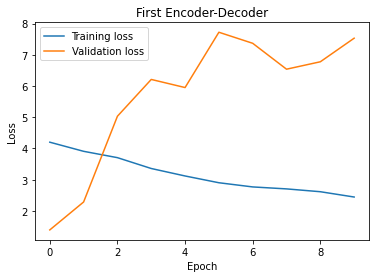

In [97]:
#Graph loss
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.plot(range(num_epochs), train_loss, val_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(["Training loss", "Validation loss"])
plt.title('First Encoder-Decoder')
plt.savefig("encoder_decoder1.png")
plt.show()

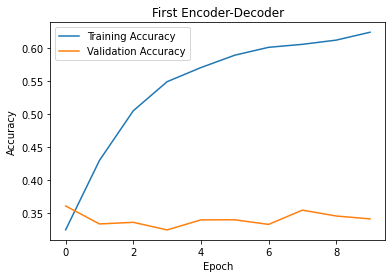

In [98]:
#graph accuracy
train_acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
plt.plot(range(num_epochs), train_acc, val_acc)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(["Training Accuracy", "Validation Accuracy"])
plt.title('First Encoder-Decoder')

plt.savefig("encoder_decoder1_acc.png")
plt.show()

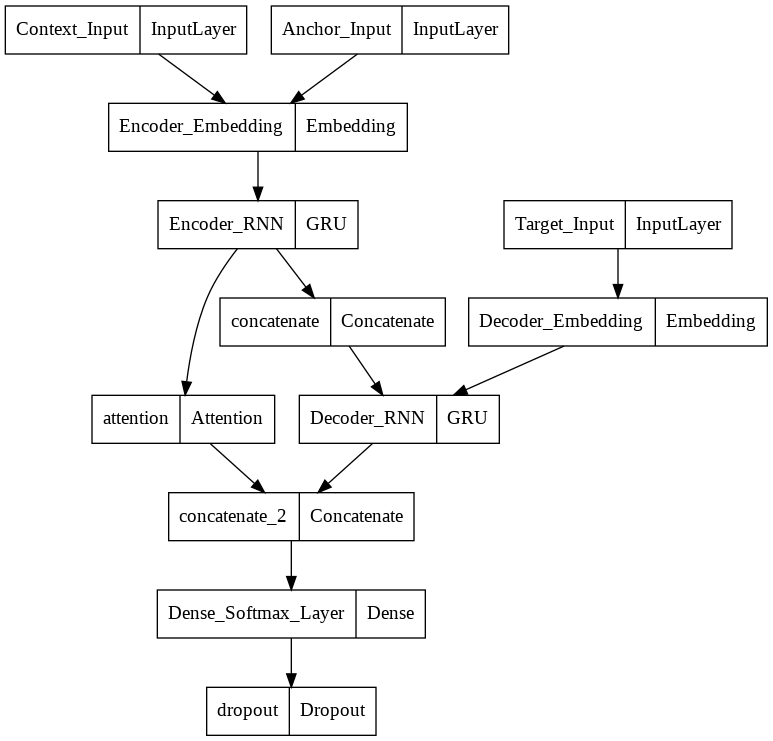

In [54]:
keras.utils.plot_model(model, to_file="Seq2Class1_Model_Graph.png")#plot first model

In [ ]:
# compile second model

model2 = keras.models.Model([model2_input1, decoder2_input], decoder2_output)

model2.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate = learning_rate), metrics = ['accuracy'])

model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 300)    2711100     ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, None, 300)    2711100     ['input_2[0][0]']                
                                                                                            

In [ ]:
#train second model
history2 = model2.fit([encoder_input1, decoder_input_2], output_decoder, 
                    epochs=num_epochs, 
                    batch_size=batch_size,
                     validation_data=([encoder_input1_val, decoder_input_2_val], output_decoder_val))

Epoch 1/10
365/365 [==============================] - 194s 509ms/step - loss: 4.0775 - accuracy: 0.3536 - val_loss: 1.3137 - val_accuracy: 0.4317
Epoch 2/10
365/365 [==============================] - 185s 508ms/step - loss: 3.8568 - accuracy: 0.4623 - val_loss: 1.4410 - val_accuracy: 0.4636
Epoch 3/10
365/365 [==============================] - 181s 497ms/step - loss: 3.6367 - accuracy: 0.5138 - val_loss: 1.8488 - val_accuracy: 0.4799
Epoch 4/10
365/365 [==============================] - 185s 508ms/step - loss: 3.3940 - accuracy: 0.5443 - val_loss: 2.3159 - val_accuracy: 0.4929
Epoch 5/10
365/365 [==============================] - 178s 489ms/step - loss: 3.1424 - accuracy: 0.5664 - val_loss: 2.7631 - val_accuracy: 0.4869
Epoch 6/10
365/365 [==============================] - 175s 480ms/step - loss: 2.9407 - accuracy: 0.5865 - val_loss: 2.9991 - val_accuracy: 0.4802
Epoch 7/10
365/365 [==============================] - 178s 489ms/step - loss: 2.7647 - accuracy: 0.5988 - val_loss: 3.0309 -

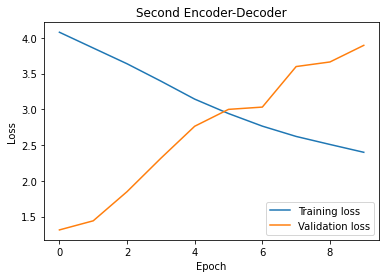

In [99]:
#graph loss
train_loss = history2.history["loss"]
val_loss = history2.history["val_loss"]
plt.plot(range(num_epochs), train_loss, val_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(["Training loss", "Validation loss"])
plt.title('Second Encoder-Decoder')
plt.savefig("encoder_decoder2_loss.png")
plt.show()

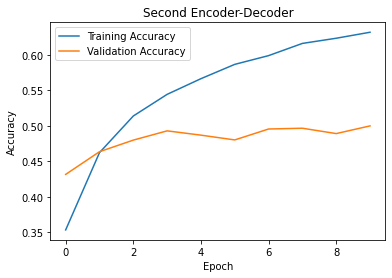

In [100]:
#graph 
train_acc = history2.history["accuracy"]
val_acc = history2.history["val_accuracy"]
plt.plot(range(num_epochs), train_acc, val_acc)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(["Training Accuracy", "Validation Accuracy"])
plt.title('Second Encoder-Decoder')

plt.savefig("encoder_decoder2_acc.png")
plt.show()

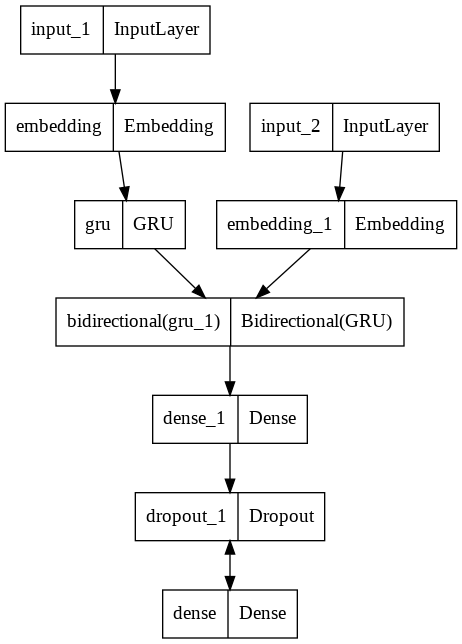

In [55]:
keras.utils.plot_model(model2, to_file="Seq2Class2_Model_Graph.png")#plot second model

In [ ]:
model.save("seq2class1_model.h5")

In [ ]:
model2.save("seq2class2_model.h5")

### Testing

In [96]:
#print correlation and weighted correlation on test set 

predictions = model.predict([encoder_input1_ver, encoder_input2_ver, input_decoder_ver])
weighted = np.matmul(predictions, np.array([[0, 0.25, 0.5, 0.75, 1]]).T)
predictions = np.argmax(predictions, axis=1)

# print(predictions)

correlation = np.corrcoef(predictions/4, output_decoder_ver/4)
weighted_corr = np.corrcoef(weighted.T[0], output_decoder_ver/4)
print(correlation[0][1])
print(weighted_corr[0][1])
# print(np.mean(val_acc))

0.12696698039661342
0.14619508585106422


In [68]:
#print accuracy

accuracy = [predictions[i] == output_decoder_ver[i] for i in range(len(predictions))]
print(np.sum(accuracy)/len(predictions))

0.3312200137080192


In [95]:
#print correlation and weighted correlation on test set 

predictions = model2.predict([encoder_input1_ver, decoder_input_2_ver])
weighted = np.matmul(predictions, np.array([[0, 0.25, 0.5, 0.75, 1]]).T)
# print(predictions[0].shape)
predictions = np.argmax(predictions, axis=1)


# print(weighted)
# print(predictions[predictions==4])

correlation = np.corrcoef(predictions/4, output_decoder_ver/4)
weighted_corr = np.corrcoef(weighted.T[0], output_decoder_ver/4)
print(correlation[0][1])
print(weighted_corr[0][1])

0.4154653856262376
0.44594316431737613


0.44594316431737613


In [66]:
#print accuracy
accuracy = [predictions[i] == output_decoder_ver[i] for i in range(len(predictions))]
print(np.sum(accuracy)/len(predictions))

0.5068540095956134


Best so far: 0.41261357886572064

In [ ]:
model2.save("seq2class")

INFO:tensorflow:Assets written to: seq2class/assets


INFO:tensorflow:Assets written to: seq2class/assets


### Ensemble Method

Uses top three models for predictions which were the base model, the stem model and the second encoder-decoder

In [ ]:
display(data_ver)

,anchor,target,context
8117,crystal thin,molecular,H01
8694,demodulator,democracy,F01
8654,deflect light,reflect light rays,H04
16907,inorganic hybrid,light dot,B32
36314,wire grid polarization,path polarization,G01
...,...,...,...
15320,heart pacemaker,patient,H01
9692,display object,display,A63
12989,fire ring,channel,E04
31211,source voltage,source current drop,G06


In [ ]:
bow_model = keras.models.load_model("context_concat_model.h5")#load the models for ensemble

In [ ]:
class_model1 = keras.models.load_model("base_model.h5")#load models for ensemble
class_model2 = keras.models.load_model("cbow_model.h5")

In [ ]:
#get predictions for the base model

def one_hot(y):
    arr = np.zeros((y.shape[0], np.max(y) + 1))
    for i in range(arr.shape[0]):
        arr[i, y[i]] = 1
    return arr

#preprocess for model 1
def model1_preprocess(data_test, id):
    def preprocess1(df, id):
        data = df.to_numpy()
        if id:
            all_ids = data[:, 0]
            sentences = [data[i, 1].lower() + " " + data[i, 2].lower() + " " + data[i, 3].lower() for i in range(len(data))]
        else:
            sentences = [data[i, 0].lower() + " " + data[i, 1].lower() + " " + data[i, 2].lower() for i in range(len(data))]
        classes = {0: 0, .25: 1, .5: 2, .75: 3, 1: 4}
        return sentences

    m1_data = preprocess1(data_test, id)
    X_train = preprocess1(train_data, False)

    tk = Tokenizer()
    tk.fit_on_texts(X_train)
    # X_train = tk.texts_to_sequences(X_train)
    X_test = tk.texts_to_sequences(m1_data)
    X_test = pad_sequences(X_test,maxlen=111, padding="post")
    return X_test

# print(X_test)
X_test = model1_preprocess(data_ver, False)
preds1 = class_model1.predict(X_test)
preds1 = np.argmax(preds1, axis=1)
print(preds1)

correlation = np.corrcoef(preds1, output_decoder_ver)
print(correlation[0][1])



[1 1 1 ... 2 1 2]
0.6084920287440745


In [ ]:
#Get predictions for Stem Model
from nltk.stem import PorterStemmer
from collections import defaultdict

def bow_preprocess(data_test):
    train_data['anchor_context'] = train_data['anchor'].str.lower() + " " + train_data['context'].str.lower()
    train_data['target_context'] = train_data['target'].str.lower() + " " + train_data['context'].str.lower()
    data_test['anchor_context'] = data_test['anchor'].str.lower() + " " + data_test['context'].str.lower()
    data_test['target_context'] = data_test['target'].str.lower() + " " + data_test['context'].str.lower()

    anchor_context = train_data['anchor_context'].to_numpy()
    target_context = train_data['target_context'].to_numpy()
    anchor_context_ver = data_test['anchor_context'].to_numpy()
    target_context_ver = data_test['target_context'].to_numpy()
    max_anchor_len = max([len(sentence) for sentence in anchor_context])
    max_target_len = max([len(sentence) for sentence in target_context])
    maxlen = max(max_anchor_len, max_target_len)
    # print(maxlen)

    tk = Tokenizer()
    tk.fit_on_texts(np.concatenate((anchor_context, target_context), axis=0))
    anchor_token = tk.texts_to_sequences(anchor_context_ver)
    target_token = tk.texts_to_sequences(target_context_ver)

    def count_num_duplicate_stems(arr, threshold=2):
        _, counts = np.unique(arr, return_counts=True)
        return np.count_nonzero(counts >= threshold)

    X_test_anchor = pad_sequences(anchor_token, maxlen=maxlen, padding='post')
    X_test_target = pad_sequences(target_token, maxlen=maxlen, padding='post')
    ps = PorterStemmer()
    sentences = (data_test['anchor'] + " " + data_test['target']).to_numpy()
    stems = [[ps.stem(w) for w in sentence.split()] for sentence in sentences]
    counts = np.array([count_num_duplicate_stems(stems) for stems in stems]).reshape(-1, 1)
    return X_test_anchor, X_test_target, counts

X_test_anchor, X_test_target, counts = bow_preprocess(data_ver)
preds2 = bow_model.predict([X_test_anchor, X_test_target, counts])
preds2 = np.argmax(preds2, axis=1)

print(preds2)

correlation = np.corrcoef(preds2, output_decoder_ver)
print(correlation[0][1])


[1 1 2 ... 1 1 1]
0.7168850542152133


In [ ]:
#Use max vote to make predictions based on the predictions of the base model,
#stem model and second encoder-decoder

def ensemble_pred(pred1, pred2, pred3):
    #max vote

    def vote(tup):
        val = np.max([tup.count(tup[0]), tup.count(tup[1]), tup.count(tup[2])])
        if val == 1:
            return tup[2]
        else:
            i = np.argmax([tup.count(tup[0]), tup.count(tup[1]), tup.count(tup[2])])
            return tup[i]

        return tup[2]

    tupes = [(a,b,c) for a,b,c in tqdm(list(zip(pred1,pred2,pred3)))]
    # print(vote(tupes[0]))
    predictions = [vote(t) for t in tupes]


    return predictions

In [102]:
ensemble_predictions = ensemble_pred(predictions, preds1, preds2)
print(ensemble_predictions)

correlation = np.corrcoef(ensemble_predictions, output_decoder_ver)
print(correlation[0][1])

  0%|          | 0/5836 [00:00<?, ?it/s]

[1, 1, 1, 1, 2, 1, 2, 2, 1, 0, 1, 0, 2, 2, 2, 1, 1, 0, 1, 1, 1, 2, 1, 2, 1, 2, 1, 0, 2, 2, 0, 1, 2, 0, 1, 0, 2, 1, 0, 0, 1, 0, 2, 2, 2, 0, 2, 0, 1, 0, 1, 1, 1, 2, 1, 1, 2, 2, 1, 2, 1, 1, 2, 2, 2, 2, 1, 0, 1, 0, 2, 1, 1, 1, 4, 2, 2, 2, 1, 3, 3, 2, 1, 2, 0, 0, 1, 2, 1, 1, 1, 2, 1, 1, 3, 1, 2, 1, 4, 2, 2, 1, 0, 1, 1, 1, 4, 2, 0, 2, 2, 0, 2, 1, 2, 0, 1, 2, 1, 2, 2, 2, 2, 1, 0, 0, 4, 2, 1, 1, 2, 2, 2, 1, 0, 2, 2, 1, 4, 2, 2, 2, 2, 2, 1, 2, 0, 0, 2, 0, 2, 1, 0, 2, 3, 1, 2, 1, 3, 2, 0, 1, 1, 2, 1, 2, 0, 2, 2, 2, 1, 0, 2, 2, 1, 2, 1, 1, 3, 1, 0, 2, 2, 0, 2, 1, 0, 2, 1, 2, 1, 2, 2, 1, 1, 1, 2, 1, 2, 1, 2, 2, 3, 0, 1, 0, 2, 3, 2, 2, 1, 2, 2, 2, 1, 1, 2, 1, 1, 1, 1, 0, 2, 1, 2, 2, 2, 2, 1, 1, 4, 0, 2, 2, 2, 2, 1, 2, 1, 0, 2, 1, 1, 1, 2, 0, 1, 0, 2, 0, 1, 0, 1, 2, 2, 2, 1, 2, 1, 2, 2, 3, 2, 3, 0, 2, 1, 0, 1, 2, 1, 2, 0, 1, 1, 0, 2, 3, 2, 1, 1, 3, 2, 1, 2, 2, 0, 2, 0, 1, 0, 1, 1, 2, 1, 2, 0, 1, 1, 1, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 0, 2, 2, 3, 3, 2, 1, 2, 1, 2, 1, 1, 2, 4, 2, 2, 1, 1, 4, 1, 2, 2, 0, 

In [103]:
accuracy = [ensemble_predictions[i] == output_decoder_ver[i] for i in range(len(ensemble_predictions))]
print(np.sum(accuracy)/len(ensemble_predictions))

0.7006511309115833


### Test Predictions

Generates predictions for the test set

In [ ]:
display(test_data)

,id,anchor,target,context
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02
1,09e418c93a776564,adjust gas flow,altering gas flow,F23
2,36baf228038e314b,lower trunnion,lower locating,B60
3,1f37ead645e7f0c8,cap component,upper portion,D06
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04
5,474c874d0c07bd21,dry corn,dry corn starch,C12
6,442c114ed5c4e3c9,tunneling capacitor,capacitor housing,G11
7,b8ae62ea5e1d8bdb,angular contact bearing,contact therapy radiation,B23
8,faaddaf8fcba8a3f,produce liquid hydrocarbons,produce a treated stream,C10
9,ae0262c02566d2ce,diesel fuel tank,diesel fuel tanks,F02


In [ ]:
X_test = model1_preprocess(test_data, True)
preds1_test = class_model1.predict(X_test)
preds1_test = np.argmax(preds1_test, axis=1)
print(preds1_test)

[2 3 1 1 0 2 2 0 1 3 1 1 0 3 3 2 0 2 1 2 1 1 2 1 1 1 0 0 0 3 0 0 2 2 1 1]


In [ ]:
X_test_anchor, X_test_target, counts = bow_preprocess(test_data)
preds2_test = bow_model.predict([X_test_anchor, X_test_target, counts])
preds2_test = np.argmax(preds2_test, axis=1)

print(preds2_test)

[0 3 2 1 0 2 2 0 1 4 1 1 0 2 2 2 0 1 2 2 1 1 1 1 2 0 0 0 0 3 0 0 2 2 1 1]


In [ ]:
anchor_test = test_data['anchor'].to_numpy()
target_test = test_data['target'].to_numpy()
context_test = test_data['context'].to_numpy()
test_set = [([token2idx[t] for t in tokenize(a)],[token2idx[t] for t in tokenize(b)],[token2idx[t] for t in ([c])]) for a,b,c in tqdm(list(zip(anchor_test, target_test, context_test)),desc="Processing Test Set:")]

encoder_input1_test = np.asarray([data[2] for data in test_set], dtype=np.int32)#context
encoder_input2_test = [data[0] for data in test_set]#anchor
encoder_input2_test = pad_sequences(encoder_input2_test, padding="post")
input_decoder_test = [data[1] for data in test_set]#target
input_decoder_test = pad_sequences(input_decoder_test)

decoder_input_2_test = [data[0]+data[1] for data in test_set]
decoder_input_2_test = pad_sequences(decoder_input_2_test, padding="post")

predictions_test = model2.predict([encoder_input1_test, decoder_input_2_test])
predictions_test = np.argmax(predictions_test, axis=1)

print(predictions_test)

Processing Test Set::   0%|          | 0/36 [00:00<?, ?it/s]

[3 1 2 1 0 3 2 0 1 3 3 1 3 3 3 1 0 1 2 1 2 1 1 1 2 0 1 0 0 3 0 0 3 2 1 1]


In [ ]:
ensemble_predictions = ensemble_pred(predictions_test, preds1_test, preds2_test)

classes = {0:0, 1:0.25, 2:0.50, 3:0.75, 4:1}

ensemble_predictions = np.array([classes[i] for i in ensemble_predictions], dtype=object)

print(ensemble_predictions)

  0%|          | 0/36 [00:00<?, ?it/s]

[0 0.75 0.5 0.25 0 0.5 0.5 0 0.25 0.75 0.25 0.25 0 0.75 0.75 0.5 0 0.25
 0.5 0.5 0.25 0.25 0.25 0.25 0.5 0 0 0 0 0.75 0 0 0.5 0.5 0.25 0.25]


In [ ]:
final = pandas.DataFrame(dtype=object)
final["id"] = test_data['id']
final['score'] = ensemble_predictions

final = final.astype(object)

display(final)

print(final.shape)

final.to_csv('submission.csv', index=False)

,id,score
0,4112d61851461f60,0
1,09e418c93a776564,0.75
2,36baf228038e314b,0.5
3,1f37ead645e7f0c8,0.25
4,71a5b6ad068d531f,0
5,474c874d0c07bd21,0.5
6,442c114ed5c4e3c9,0.5
7,b8ae62ea5e1d8bdb,0
8,faaddaf8fcba8a3f,0.25
9,ae0262c02566d2ce,0.75


(36, 2)


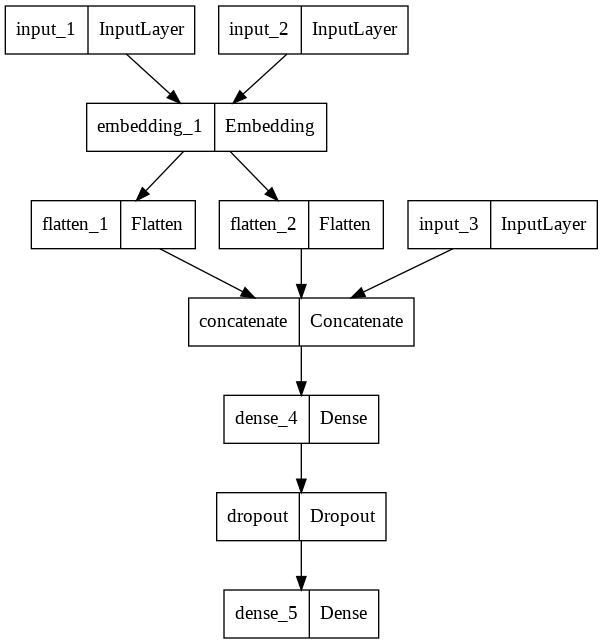

In [ ]:
keras.utils.plot_model(bow_model, to_file="Anchor_Model_Graph.png")

In [ ]:
test_read = pandas.read_csv('submission.csv', dtype=object)
test_read.to_csv('sub.csv', index=False)